# Assignment 4
Jan Widanka

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

### Black-Scholes price

In [2]:
def payoff(X, K, option_type):
    if option_type == 'call':
        return np.maximum((X - K), 0)
    else:
        return np.maximum((K - X), 0)

In [3]:
def bs_price(X, K, r, sigma, T, t, call=True):
    d_1 = (np.log(X / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d_2 = d_1 - sigma * np.sqrt(T - t)
    if call:
        price = X * stats.norm.cdf(d_1) - K * np.exp(-r * (T - t)) * stats.norm.cdf(d_2)
    else:
        price = K * np.exp(-r * (T-t)) * stats.norm.cdf(-d_2) - X * stats.norm.cdf(-d_1)

    return price

## Monte carlo

In [4]:
def monte_carlo(S_0, K, r, sigma, T, N, option_type):
    eps = np.random.normal(0, 1, N)
    S_T = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * eps)

    if option_type == 'call':
        payoff = np.maximum(S_T - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - S_T, 0)

    price = np.exp(-r*T) * np.sum(payoff) / N
    return price

In [4]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 0.5
N = 100000

In [6]:
%%time
call_option_price = monte_carlo(S_0, K, r, sigma, T, N, 'call')

Wall time: 5.14 ms


In [7]:
call_option_price

6.884850810800698

In [8]:
%%time
put_option_price = monte_carlo(S_0, K, r, sigma, T, N, 'put')

Wall time: 3.96 ms


In [9]:
put_option_price

4.419163093258549

### B-S price

In [10]:
bs_call = bs_price(S_0, K, r, sigma, T, 0, call=True)
bs_call

6.888728577680624

In [11]:
bs_put = bs_price(S_0, K, r, sigma, T, 0, call=False)
bs_put

4.41971978051388

### Simulation for different N

In [5]:
N_min = 200
N_max = 100100
step = 100
Ns = np.arange(N_min, N_max, step)

In [13]:
european_call_diff_N_MC = [monte_carlo(S_0, K, r, sigma, T, N, 'call') for N in Ns]
european_put_diff_N_MC = [monte_carlo(S_0, K, r, sigma, T, N, 'put') for N in Ns]

### European call option

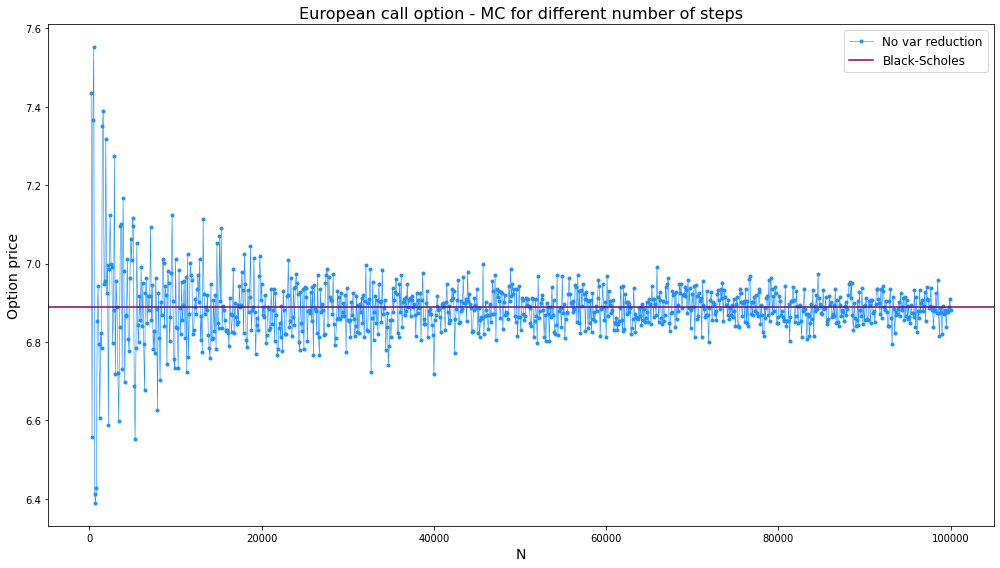

In [54]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, european_call_diff_N_MC, marker = '.', lw = 0.6, label='No var reduction', color='dodgerblue')
plt.axhline(bs_call, color='purple', label='Black-Scholes')
plt.title("European call option - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### European put option

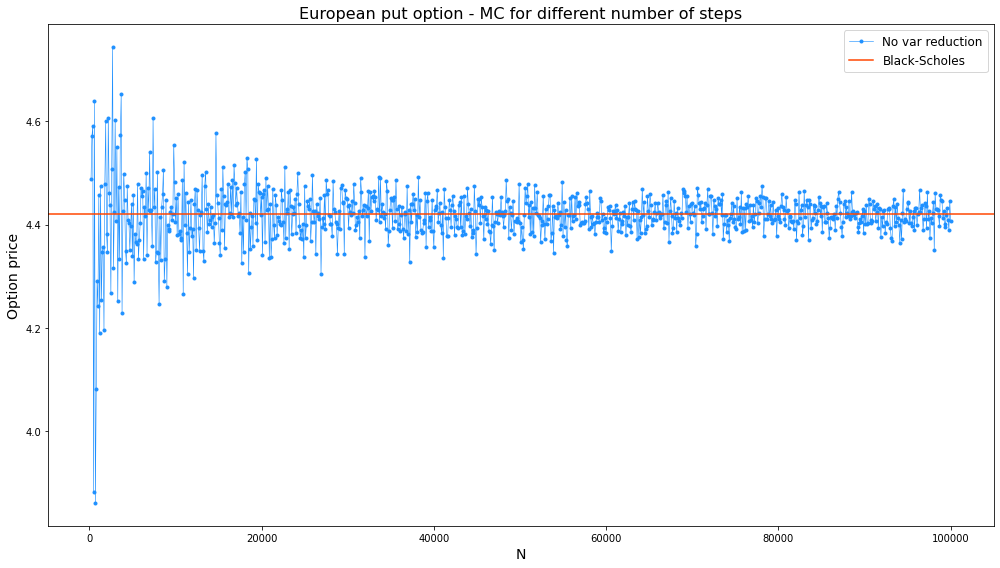

In [55]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, european_put_diff_N_MC, marker = '.', lw = 0.6, label='No var reduction', color='dodgerblue')
plt.axhline(bs_put, color='orangered', label='Black-Scholes')
plt.title("European put option - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

## Antithetic variate

In [16]:
def monte_carlo_antithetic_var(S_0, K, r, sigma, T, N, option_type):
    Z_1 = np.random.normal(0, 1, N//2)

    S_T = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * Z_1)
    S_T_2 = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * (-Z_1))

    if option_type == 'call':
        payoffs = 0.5 * (np.maximum(S_T - K, 0) + np.maximum(S_T_2 - K, 0))
    elif option_type == 'put':
        payoffs = 0.5 * (np.maximum(K - S_T, 0) + np.maximum(K - S_T_2, 0))

    price = np.exp(-r*T) * np.mean(payoffs)
    
    return price

### Results

In [17]:
ant_var_mc_call_diff_N = [monte_carlo_antithetic_var(S_0, K, r, sigma, T, N, 'call') for N in Ns]
ant_var_mc_put_diff_N = [monte_carlo_antithetic_var(S_0, K, r, sigma, T, N, 'put') for N in Ns]

### European call

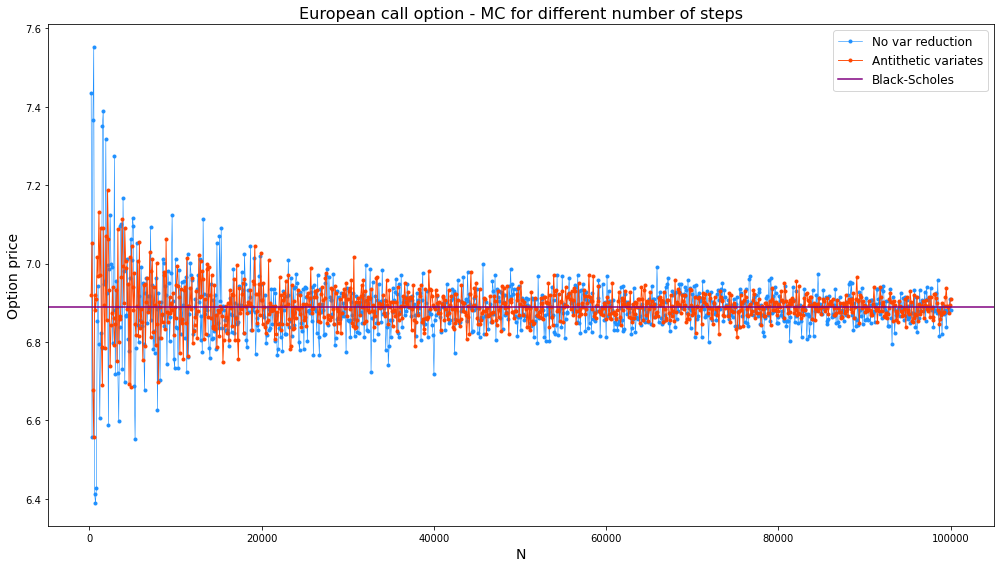

In [18]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, european_call_diff_N_MC, marker = '.', lw = 0.6, label = 'No var reduction', color='dodgerblue')
plt.plot(Ns, ant_var_mc_call_diff_N, marker = '.', lw = 0.9, color='orangered', label = 'Antithetic variates')
plt.axhline(bs_call, color='purple', label='Black-Scholes')
plt.title("European call option - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### European put

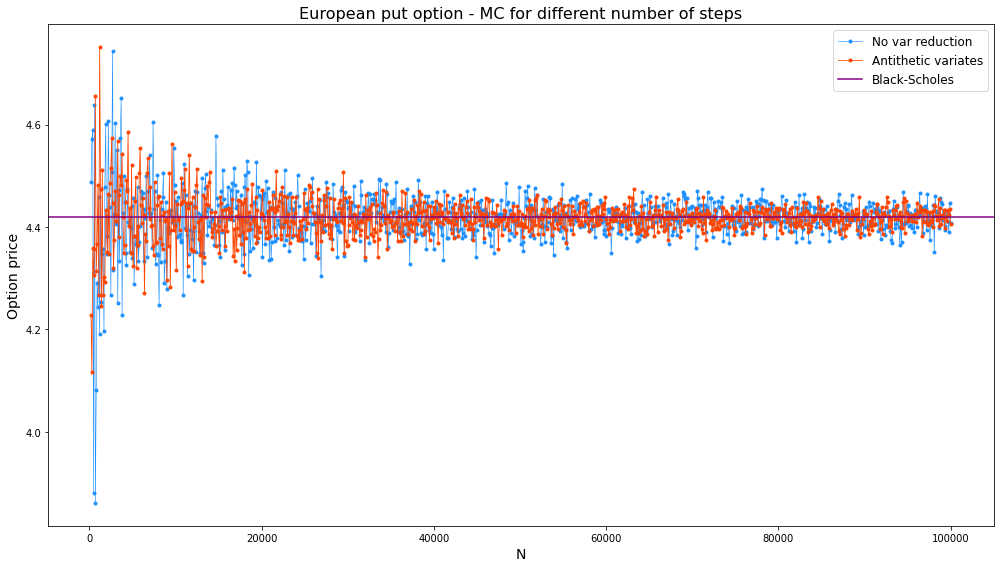

In [19]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, european_put_diff_N_MC, marker = '.', lw = 0.6, label = 'No var reduction', color='dodgerblue')
plt.plot(Ns, ant_var_mc_put_diff_N, marker = '.', lw = 0.8, color='orangered', label = 'Antithetic variates')
plt.axhline(bs_put, color='purple', label='Black-Scholes')
plt.title("European put option - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

## Control variate

In [20]:
def monte_carlo_control_var(S_0, K, r, sigma, T, N, option_type):
    #pilot
    Z_1 = np.random.normal(0, 1, 1000)
    S_T_pilot = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * Z_1)
    control_variate_pilot = S_T_pilot
    exp_value = S_0 * np.exp(r * T)
    payoffs_pilot = payoff(S_T_pilot, K, option_type)
    cov_z_1 = np.cov(control_variate_pilot, payoffs_pilot)[0, 1]
    var_z_1 = np.var(control_variate_pilot)
    c = - cov_z_1 / var_z_1
    
    Z_2 = np.random.normal(0, 1, N)
    S_T = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * Z_2)
    ctrl_variate = S_T
    payoffs = payoff(S_T, K, option_type)

    adjusted_payoffs = payoffs + c * (ctrl_variate - exp_value)
    option_price = np.exp(-r * T) * np.mean(adjusted_payoffs)
    
    return option_price

In [21]:
contr_var_call = [monte_carlo_control_var(S_0, K, r, sigma, T, N, 'call') for N in Ns]
contr_var_put = [monte_carlo_control_var(S_0, K, r, sigma, T, N, 'put') for N in Ns]

### European call

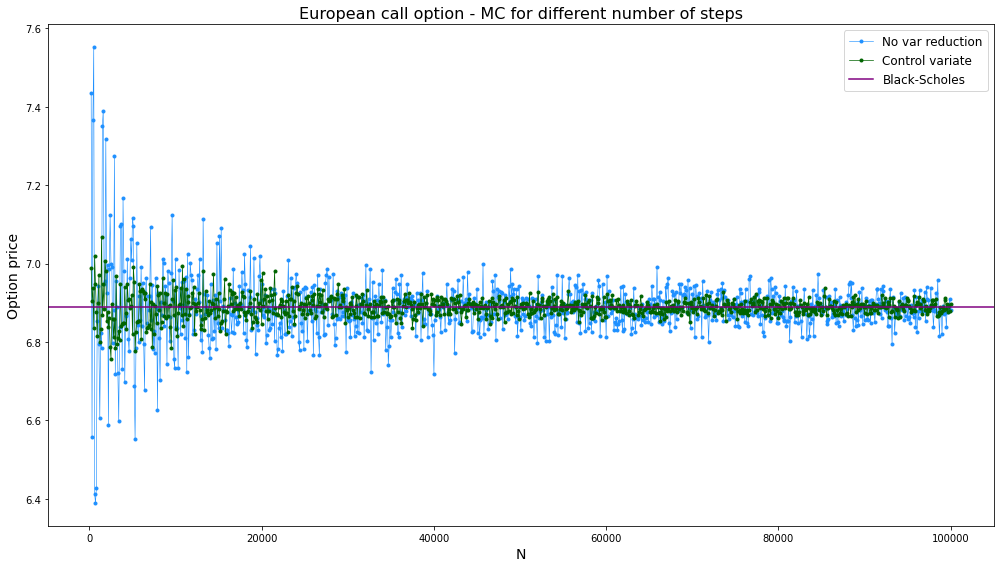

In [22]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, european_call_diff_N_MC, marker = '.', lw = 0.6, label = 'No var reduction', color='dodgerblue')
plt.plot(Ns, contr_var_call, marker = '.', lw = 0.7, color='darkgreen', label = 'Control variate')
plt.axhline(bs_call, color='purple', label = 'Black-Scholes')
plt.title("European call option - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### European put

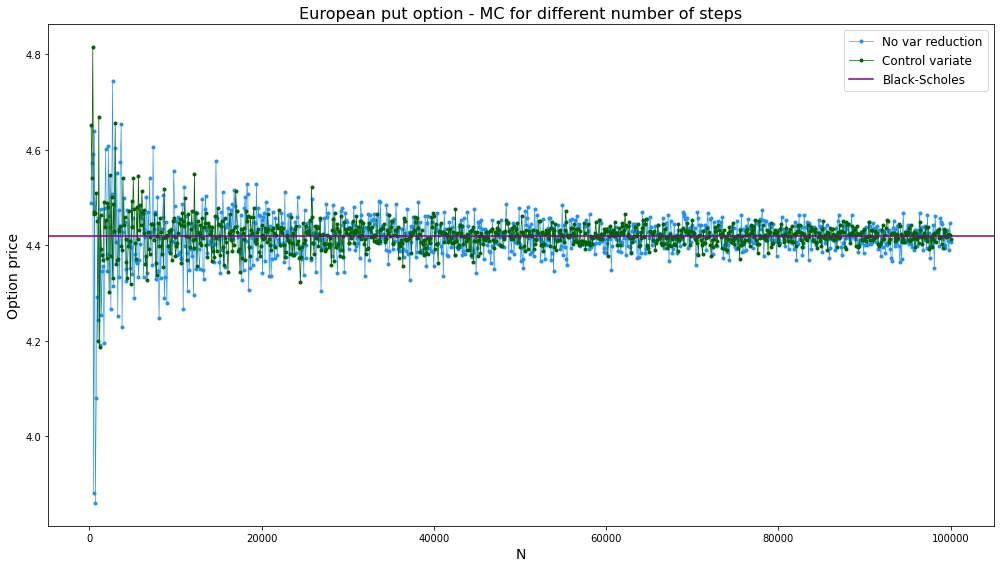

In [23]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, european_put_diff_N_MC, marker = '.', lw = 0.6, label = 'No var reduction', color='dodgerblue')
plt.plot(Ns, contr_var_put, marker = '.', lw = 0.7, color='darkgreen', label = 'Control variate')
plt.axhline(bs_put, color='purple', label='Black-Scholes')
plt.title("European put option - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### Variance analysis

In [24]:
european_call_MC = [monte_carlo(S_0, K, r, sigma, T, 10000, 'call') for _ in range(10000)]
european_put_MC = [monte_carlo(S_0, K, r, sigma, T, 10000, 'put') for _ in range(10000)]

european_call_MC_antithetic_variates = [monte_carlo_antithetic_var(S_0, K, r, sigma, T, 10000, 'call') for _ in range(10000)]
european_put_MC_antithetic_variates = [monte_carlo_antithetic_var(S_0, K, r, sigma, T, 10000, 'put') for _ in range(10000)]

european_call_MC_control_variate = [monte_carlo_control_var(S_0, K, r, sigma, T, 10000, 'call') for _ in range(10000)]
european_put_MC_control_variate = [monte_carlo_control_var(S_0, K, r, sigma, T, 10000, 'put') for _ in range(10000)]

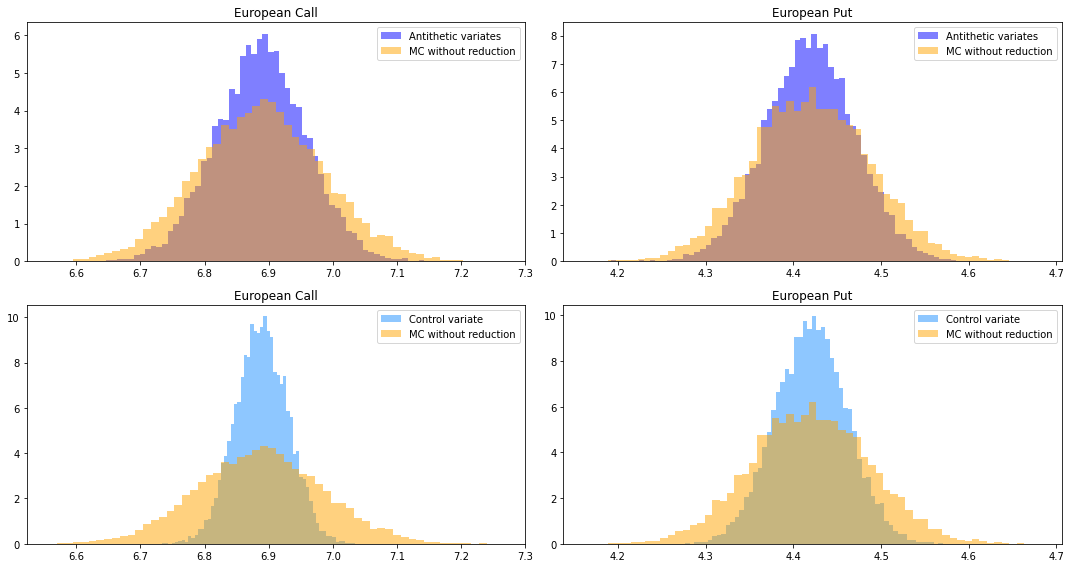

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

axs[0, 0].hist(european_call_MC_antithetic_variates, bins='auto', density=True, alpha=0.5, label='Antithetic variates', color='blue')
axs[0, 0].hist(european_call_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[0, 0].set_title('European Call')
axs[0, 0].legend()

axs[0, 1].hist(european_put_MC_antithetic_variates, bins='auto', density=True, alpha=0.5, label='Antithetic variates', color='blue')
axs[0, 1].hist(european_put_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[0, 1].set_title('European Put')
axs[0, 1].legend()

axs[1, 0].hist(european_call_MC_control_variate, bins='auto', density=True, alpha=0.5, label='Control variate', color='dodgerblue')
axs[1, 0].hist(european_call_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[1, 0].set_title('European Call')
axs[1, 0].legend()

axs[1, 1].hist(european_put_MC_control_variate, bins='auto', density=True, alpha=0.5, label='Control variate', color='dodgerblue')
axs[1, 1].hist(european_put_MC, bins='auto', alpha=0.5, density=True, label='MC without reduction', color='orange')
axs[1, 1].set_title('European Put')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Lookback options

In [6]:
def lookback_option_floating_strike_payoff(S, S_T, option_type):
    if option_type == 'call_floating_strike':
        return S_T - S
    elif option_type == 'put_floating_strike':
        return S - S_T
    else:
        raise ValueError("Invalid option_type")

In [7]:
def lookback_option_price_MC(S_0, K, r, sigma, T, k, N, option_type):
    dt = T / k
    ts = np.arange(0, T + dt, dt)
    Z = np.random.normal(0, 1, size=(N, k+1))
    S_t = S_0 * np.exp((r - sigma**2 / 2) * ts + sigma * np.sqrt(ts) * Z)
    S_T = [S_t[i][-1] for i in range(N)]
    
    if option_type == 'call_floating_strike':
        S = np.array([np.min(S_t[i]) for i in range(N)])
    elif option_type == 'put_floating_strike':
        S = np.array([np.max(S_t[i]) for i in range(N)])

    payoffs = lookback_option_floating_strike_payoff(S, S_T, option_type)
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

In [8]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 0.5
k = int(T*252)

### Lookback call with floating strike

In [9]:
lookback_option_MC = [lookback_option_price_MC(S_0, K, r, sigma, T, k, N, 'call_floating_strike') for N in Ns]

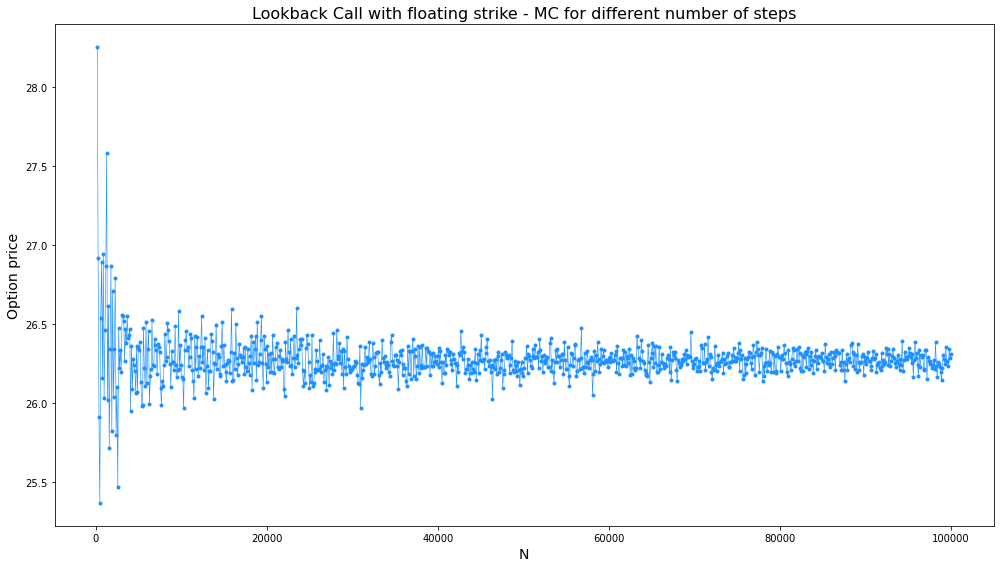

In [10]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, lookback_option_MC, marker = '.', lw = 0.6, color='dodgerblue')
plt.title("Lookback Call with floating strike - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.tight_layout()
plt.show()

### Lookback put with floating strike

In [31]:
lookback_put_option_MC = [lookback_option_price_MC(S_0, K, r, sigma, T, k, N, 'put_floating_strike') for N in Ns]

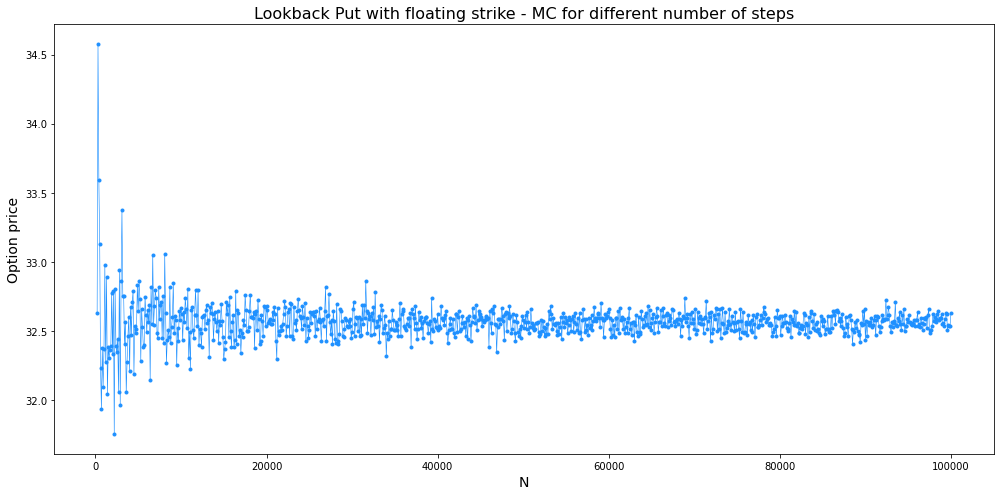

In [32]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, lookback_put_option_MC, marker = '.', lw = 0.6, color='dodgerblue')
plt.title("Lookback Put with floating strike - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.tight_layout()
plt.show()

## Antithetic variate

In [17]:
def lookback_antithetic_var(S_0, K, r, sigma, T, k, N, option_type):
    dt = T / k
    ts = np.arange(0, T + dt, dt)
    Z_1 = np.random.normal(0, 1, size=(N//2, k + 1))

    S_t = S_0 * np.exp((r - sigma**2 / 2) * ts + sigma * np.sqrt(ts) * Z_1)
    S_t_2 = S_0 * np.exp((r - sigma**2/2) * ts + sigma * np.sqrt(ts) * (-Z_1))

    S_T = [S_t[i][-1] for i in range(N//2)]
    S_T_2 = [S_t_2[i][-1] for i in range(N//2)]
    
    if option_type == 'call_floating_strike':
        S = np.array([np.min(S_t[i]) for i in range(N//2)])
        S_2 = np.array([np.min(S_t_2[i]) for i in range(N//2)])
        payoffs = 0.5 * (np.maximum(S_T - S, 0) + np.maximum(S_T_2 - S_2, 0))
    elif option_type == 'put_floating_strike':
        S = np.array([np.max(S_t[i]) for i in range(N//2)])
        S_2 = np.array([np.max(S_t_2[i]) for i in range(N//2)])
        payoffs = 0.5 * (np.maximum(S - S_T, 0) + np.maximum(S_2 - S_T_2, 0))

    option_price = np.exp(-r*T) * np.mean(payoffs)
    
    return option_price

### Lookback call with floating strike

In [34]:
antithetic_var_lookback_call = [lookback_antithetic_var(S_0, K, r, sigma, T, k, N, 'call_floating_strike') for N in Ns]

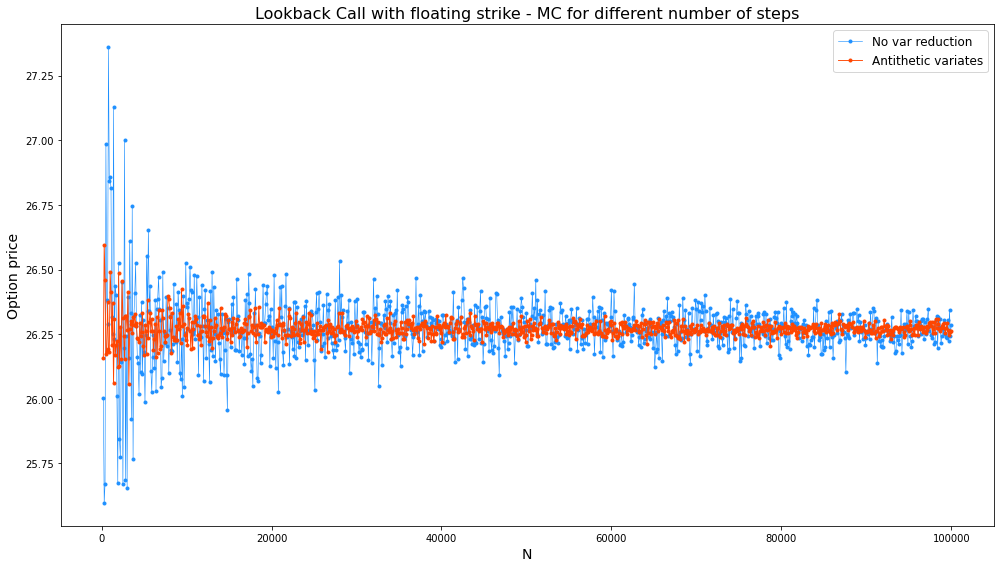

In [35]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, lookback_option_MC, marker = '.', lw = 0.6, label='No var reduction', color='dodgerblue')
plt.plot(Ns, antithetic_var_lookback_call, marker = '.', lw = 0.9, label='Antithetic variates', color='orangered')
plt.title("Lookback Call with floating strike - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### Lookback put with floating strike

In [36]:
%%time
antithetic_var_lookback_put = [lookback_antithetic_var(S_0, K, r, sigma, T, k, N, 'put_floating_strike') for N in Ns]

Wall time: 7min 7s


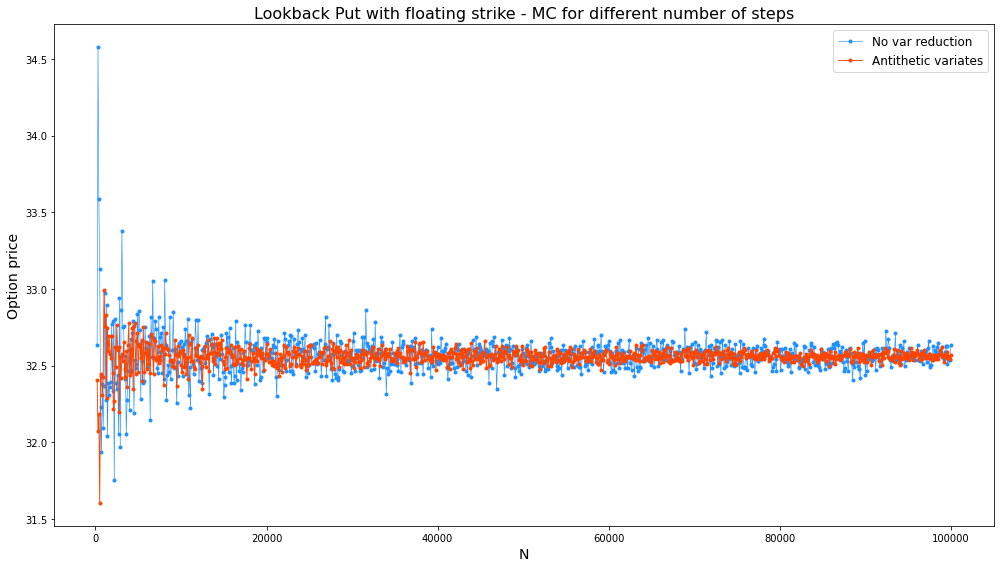

In [37]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, lookback_put_option_MC, marker = '.', lw = 0.6, label='No var reduction', color='dodgerblue')
plt.plot(Ns, antithetic_var_lookback_put, marker = '.', lw = 0.9, label='Antithetic variates', color='orangered')
plt.title("Lookback Put with floating strike - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

## Control variate

In [12]:
#just the change of the name, because of the previous 'call' version
def payoff_2(S, K, option_type):
    if option_type == 'call_floating_strike':
        return S - K
    else:
        return K - S

In [13]:
def lookback_control_var(S_0, K, r, sigma, T, k, N, option_type):
    dt = T / k
    ts = np.arange(0, T + dt, dt)
    Z_1 = np.random.normal(0, 1, 1000)
    
    S_T_pilot =  S_0 * np.exp((r - sigma**2 / 2) * T + sigma * np.sqrt(T) * Z_1)
    ctrl_variate_pilot = S_T_pilot
    exp_value = S_0 * np.exp(r * T)
    pilot_payoffs = payoff_2(S_T_pilot, K, option_type)
    cov_Z_1 = np.cov(ctrl_variate_pilot, pilot_payoffs)[0, 1]
    var_Z_1 = np.var(ctrl_variate_pilot)
    c = - cov_Z_1 / var_Z_1

    Z_2 = np.random.normal(0, 1, (N, k+1))
    S_t = S_0 * np.exp((r - sigma**2 / 2) * ts + sigma * np.sqrt(ts) * Z_2)
    S_T = [S_t[i][-1] for i in range(N)]
    ctrl_variate = S_T
    if option_type == 'call_floating_strike':
        S = np.array([np.min(S_t[i]) for i in range(N)])
    elif option_type == 'put_floating_strike':
        S = np.array([np.max(S_t[i]) for i in range(N)])

    payoffs = lookback_option_floating_strike_payoff(S, S_T, option_type)

    adjusted_payoffs = payoffs + c * (ctrl_variate - exp_value)
    option_price = np.exp(-r * T) * np.mean(adjusted_payoffs)
    
    return option_price

### Lookback call with floating strike

In [14]:
lookback_call_cont_var = [lookback_control_var(S_0, K, r, sigma, T, k, N, 'call_floating_strike') for N in Ns]

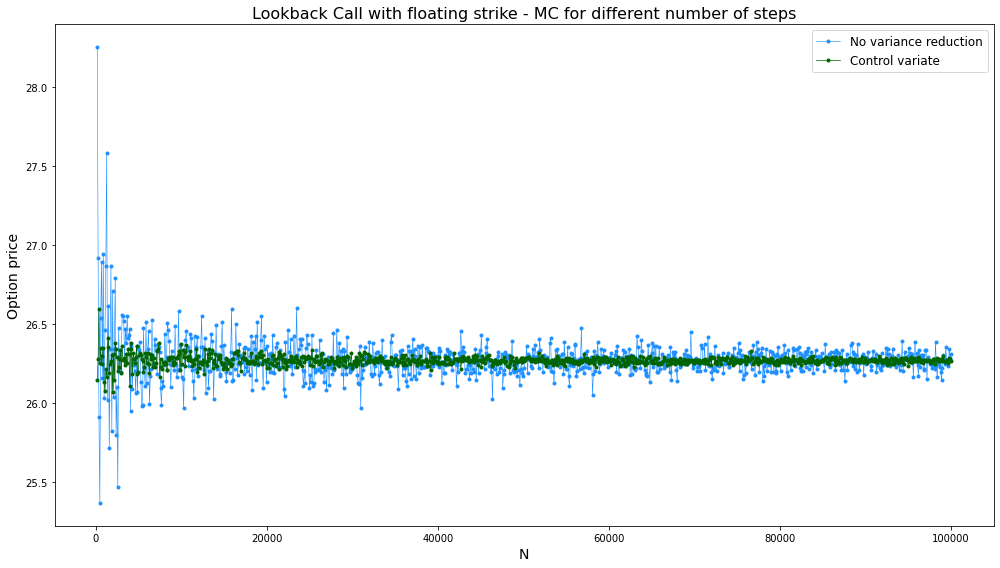

In [15]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, lookback_option_MC, marker = '.', lw = 0.6, label='No variance reduction', color='dodgerblue')
plt.plot(Ns, lookback_call_cont_var, marker = '.', lw = 0.7, color='darkgreen', label = 'Control variate')
plt.title("Lookback Call with floating strike - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### Lookback put with floating strike

In [50]:
lookback_put_cont_var = [lookback_control_var(S_0, K, r, sigma, T, k, N, 'put_floating_strike') for N in Ns]

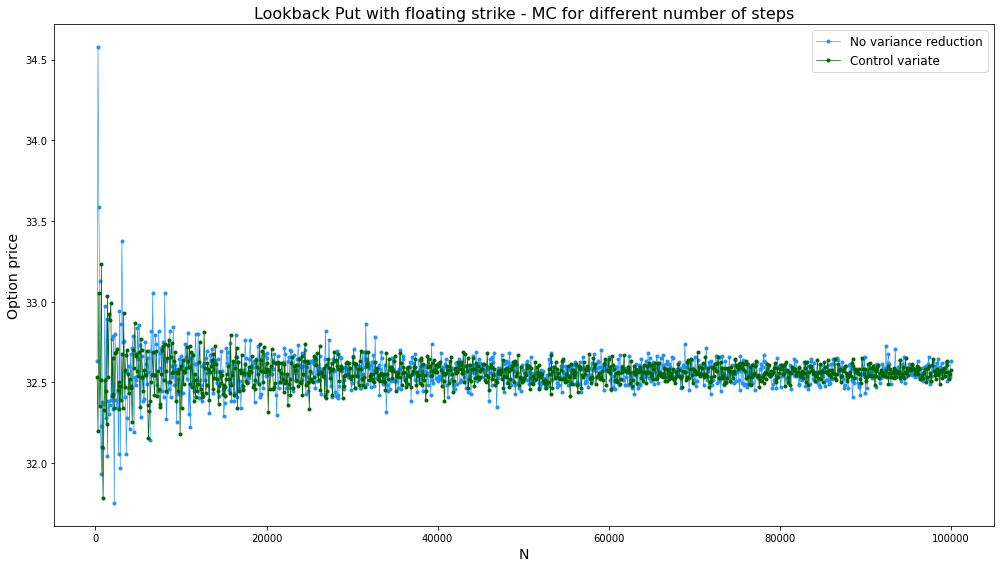

In [51]:
plt.figure(figsize = (14, 8))

plt.plot(Ns, lookback_put_option_MC, marker = '.', lw = 0.6, label='No variance reduction', color='dodgerblue')
plt.plot(Ns, lookback_put_cont_var, marker = '.', lw = 0.7, color='darkgreen', label = 'Control variate')
plt.title("Lookback Put with floating strike - MC for different number of steps", fontsize = 16)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Option price", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### Variance analysis

In [20]:
lookback_call_var_MC = [lookback_option_price_MC(S_0, K, r, sigma, T, k, 2000, 'call_floating_strike') for _ in range(1000)]
lookback_put_var_MC = [lookback_option_price_MC(S_0, K, r, sigma, T, k, 2000, 'put_floating_strike') for _ in range(1000)]

lookback_call_MC_antithetic_variates = [lookback_antithetic_var(S_0, K, r, sigma, T, k, 2000, 'call_floating_strike') for _ in range(1000)]
lookback_put_MC_antithetic_variates = [lookback_antithetic_var(S_0, K, r, sigma, T, k, 2000, 'put_floating_strike') for _ in range(1000)]

lookback_call_MC_control_variate = [lookback_control_var(S_0, K, r, sigma, T, k, 2000, 'call_floating_strike') for _ in range(1000)]
lookback_put_MC_control_variate = [lookback_control_var(S_0, K, r, sigma, T, k, 2000, 'put_floating_strike') for _ in range(1000)]

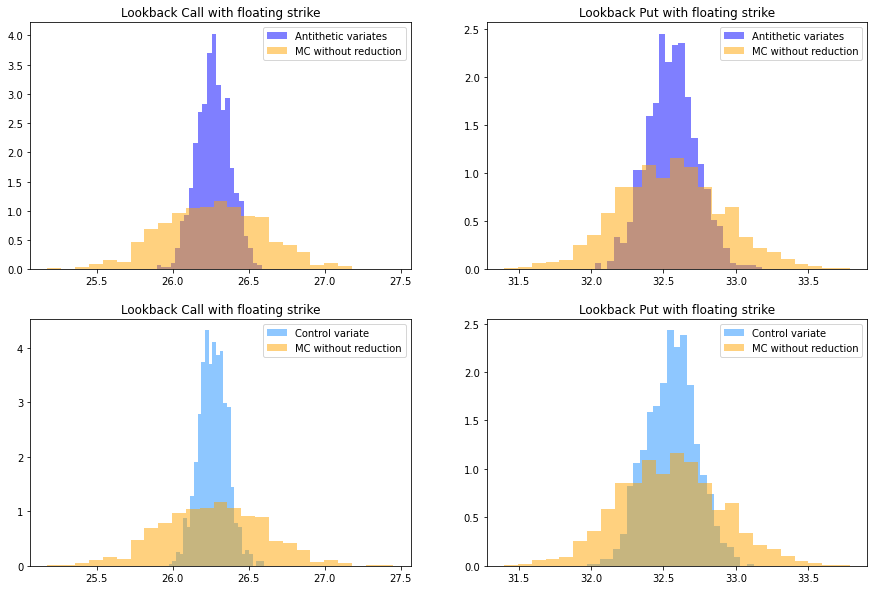

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(lookback_call_MC_antithetic_variates, bins='auto', density=True, alpha=0.5, label='Antithetic variates', color='blue')
axs[0, 0].hist(lookback_call_var_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[0, 0].set_title('Lookback Call with floating strike')
axs[0, 0].legend()

axs[0, 1].hist(lookback_put_MC_antithetic_variates, bins='auto', density=True, alpha=0.5, label='Antithetic variates', color='blue')
axs[0, 1].hist(lookback_put_var_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[0, 1].set_title('Lookback Put with floating strike')
axs[0, 1].legend()

axs[1, 0].hist(lookback_call_MC_control_variate, bins='auto', density=True, alpha=0.5, label='Control variate', color='dodgerblue')
axs[1, 0].hist(lookback_call_var_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[1, 0].set_title('Lookback Call with floating strike')
axs[1, 0].legend()

axs[1, 1].hist(lookback_put_MC_control_variate, bins='auto', density=True, alpha=0.5, label='Control variate', color='dodgerblue')
axs[1, 1].hist(lookback_put_var_MC, bins='auto', density=True, alpha=0.5, label='MC without reduction', color='orange')
axs[1, 1].set_title('Lookback Put with floating strike')
axs[1, 1].legend()

plt.show()

### Conclusions
The analysis of Monte Carlo method with variance reduction showed some interesting aspects. The method using Control variate performed better than the Monte Carlo with Antithetic variates in case of European call option pricing. Considering both Lookbacks (call and put option with floating strike) option, we can say the best convergence was obtained for Monte Carlo using Control variate.  